**Domain Data preparation** \\
The first step is to download the Amazon Product Review dataset from the UCSD repository and preprocess the data. \\

We are using metadata and not the reviews for training, as we want to model to get familiarized with the different types of products and their uses. \\

We have uploaded the dataset to our Google drive (can also use wget function to download it but it takes some time). In preprocessing, we will drop the columns we do not need. We are not editing the text as it is domain training. We will do more detailed preprocessing such as removing of unwanted characters, removal of stopwords, etc. in the task specific training

In [ ]:
import gzip
import json 
import pandas as pd 

#Unzipping the data
data = []
with gzip.open('/content/drive/MyDrive/591 Project /meta_All_Beauty.json.gz') as f:
  for l in f:
    data.append(json.loads(l.strip()))

In [ ]:
print(data[0])

{'category': [], 'tech1': '', 'description': ["Loud 'N Clear Personal Sound Amplifier allows you to turn up the volume on what people around you are saying, listen at the level you want without disturbing others, hear a pin drop from across the room."], 'fit': '', 'title': "Loud 'N Clear&trade; Personal Sound Amplifier", 'also_buy': [], 'tech2': '', 'brand': 'idea village', 'feature': [], 'rank': '2,938,573 in Beauty & Personal Care (', 'also_view': [], 'details': {'ASIN: ': '6546546450'}, 'main_cat': 'All Beauty', 'similar_item': '', 'date': '', 'price': '', 'asin': '6546546450', 'imageURL': [], 'imageURLHighRes': []}


In [ ]:
#Loading the dataset into a Dataframe
df = pd.DataFrame.from_dict(data)

In [ ]:
df.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [ ]:
print(df.description.iloc[0], df.title.iloc[0])

["Loud 'N Clear Personal Sound Amplifier allows you to turn up the volume on what people around you are saying, listen at the level you want without disturbing others, hear a pin drop from across the room."] Loud 'N Clear&trade; Personal Sound Amplifier


In [ ]:
df.description.iloc[1][0]

'No7 Lift & Luminate Triple Action Serum 50ml by Boots'

In [ ]:
def edit_description(desc):
  if desc==[]:
    return ''
  else:
    return desc[0]

In [ ]:
df['description'] = df.apply(lambda row: edit_description(row['description']), axis = 1)

In [ ]:
df.head()

In [ ]:
#Filtering the dataset 
# 1) Check which all rows contain NA entries for title and description
df = df.fillna('')
removed_content_df = df[((df.title == '') | (df.description==''))]
filtered_df = df[((df.title !='') & (df.description!=''))]

In [ ]:
removed_content_df.head()

In [ ]:
len(removed_content_df)

18309

In [ ]:
len(filtered_df)

14583

In [ ]:
filtered_df['custom_input'] = filtered_df['title'] + filtered_df['description']

<ipython-input-6-9cb3ee3c630f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['custom_input'] = filtered_df['title'] + filtered_df['description']


In [ ]:
train_df = filtered_df[['custom_input']]

In [ ]:
train_df.head()

,custom_input
0,Loud 'N Clear&trade; Personal Sound AmplifierL...
1,No7 Lift &amp; Luminate Triple Action Serum 50...
2,No7 Stay Perfect Foundation Cool Vanilla by No...
4,Lacto Calamine Skin Balance Oil control 120 ml...
5,Mary Kay Satin Hands Hand Cream Travel MINI Si...


**Data Visualization** \\
Will be checking the wordcloud to visually see which word occured the most in the training data.


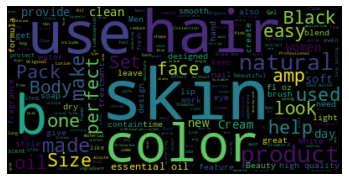

In [ ]:
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud 

stopwords = stopwords.words('english')
stopwords = stopwords + ["br","href"]
text = " ".join(input for input in train_df.custom_input)

wordcloud = WordCloud(stopwords=stopwords).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Data Splitting** \\
Splitting the data into train and validation sets

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch 
from transformers import BertTokenizer, BertForMaskedLM
from torch.utils.data import DataLoader, Dataset

We use BertForPretraining when we want the model to learn about the style of language, so that it performs better in use cases

In [ ]:
train_data = train_df.sample(frac=0.8, random_state=42)
val_data = train_df.drop(train_data.index)
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Tokenization** \\
Tokenize the text data using the BERT tokenizer. This involves converting the text into a sequence of tokens that can be fed into the BERT model.

Due to limited size of the dataset we are using the base model with 110M parameters and not the BERT large model which has 330M parameters. 

There are several other options of pretrained tokenizers, but we are using BERT Tokenizer. A tokenizer splits text into tokens according to a set of rules. The tokens are converted into numbers and then tensors, which become the model inputs. Finally, you want the tokenizer to return the actual tensors that get fed to the model. Set the return_tensors parameter to either pt for PyTorch, or tf for TensorFlow

In [ ]:
#DataLoader expects 2 additional fucntions apart from the initialized Dataset object - getitem and len methods
class AmazonReviewsDataset(Dataset):
  #This class handles the conversion of data into a Dataset object
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer
    def __getitem__(self, index): 
        # print(f"Index: {index}, Data length: {len(self.data)}")
        title_desc = self.data.loc[index, 'custom_input']
        input = self.tokenizer(title_desc, return_tensors='pt', add_special_tokens=True, max_length =512, truncation=True, padding='max_length')
        input_ids = input.input_ids.squeeze()
        attention_mask = input.attention_mask.squeeze()
        labels = input_ids.clone()
        # input['label'] = input.input_ids.detach().clone()
        #creates a copy of input ids as the label 
        #Now we are creating the mask - each non-special token has a 15% chance of getting masked 
        # rand = torch.rand(input.input_ids.shape[1]) 
        rand = torch.rand(input_ids.shape)
        #create a tensor of float values (b/w 0-1) that have equal dimensions as our input
        mask_arr = (rand<0.15) * (input.input_ids[0]!=101) * (input.input_ids[0]!=102) * (input.input_ids[0]!=0)
        # print(mask_arr)
        selection = torch.flatten(mask_arr.nonzero()).tolist()
        # input.input_ids[0][selection] = 103
        input_ids[selection] = 103
        return {'input_ids':input_ids, 'attention_mask': attention_mask, 'labels': labels}
    def __len__(self):
        return len(self.data)
# train_df.reset_index(inplace=True)
train_dataset = AmazonReviewsDataset(train_data, tokenizer)
validation_dataset = AmazonReviewsDataset(val_data, tokenizer)

In [ ]:
train_dataset.__getitem__(0)

**Model Domain Training** \\
We are training model from the scratch for 20 epochs on the dataset in a  Masked Language Modeling fashion. BERT can be trained in 2 possible ways - 1) MLM 2) NSP (Next Sequence Prediction). 

[SEP] - 102
[MASK] - 103
[CLS] - 101
We are only conserned about the input_ids and won't give much attention to token_type_ids (useful only when we have more than one sequences) and attention_mask (tells whether we have to attend a token or not). 

BertForPretraining class contains both MLM and NSP heads. (During initialization may get a warning that we have to train th emodel before using it for any downstream task). Therefore we have to create a next sentence prediction label, create input ids consisting of 2 sentences, and then do the masking on these to proceed with the model training. Therefore, due to the limitation of multiple sentence dataset, we will be using BertForMaskedLM approach

In [ ]:
len(train_dataset)

14583

If we directly call the tokenizer instead of using the encode function, it will returnthe token_ids and attention mask as well. And therefore we do not have to create input_mask on our own. Moreover, as we have specified that we want the returned output to be a pytorch tensor, therefore no need to use torch.tensor() function while returning the tokenized input

In [ ]:
#We won't need to focus on the token_ids, because we are doing MLM
#For training we need input_ids with the mask tokens and output labels (without the mask tokens) - done right after tokenizing 

#Now we have our tokens in correct format and dimensioanlity but we need to process them through DataLoader object
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=16, shuffle=True)

In [ ]:
#Checking if we have a GPU and if we have move the model to it 
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [ ]:
#Enabling model's training mode
model.train()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [ ]:
from transformers import AdamW
optim = AdamW(model.parameters(), lr=1e-5)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from tqdm import tqdm
#tqdm allows us to create a progress bar during training 

epochs = 2
#Be careful with number of epochs when training transformer models - they tend to overfit very easily 

for epoch in range(epochs):
  #Start training loop 
  loop = tqdm(train_loader, leave = True)
  #leave=True, leaves a progress bar rather than replacing it with a new one after each epoch
  #iterating over batches in loop
  for batch in loop:
    optim.zero_grad()
    #Rather than having any randomly initialized gradients at the start, we make them zero 
    input_ids = batch['input_ids'].to(device) 
    #Also want to move the tensors to GPU along with the model
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    #Extracting loss from those outputs
    loss = outputs.loss #a tensor
    loss.backward() #Calculates loss for every parameter in our model, now can do the gradient update using the optimizer
    optim.step() #Takes a step to optimize every parameter in our model

    loop.set_description(f'Epoch {epoch}') 
    loop.set_postfix(loss=loss.item())